# Energy Monitoring using atoti

In [1]:
import atoti as tt

session = tt.create_session("Emgt_nrj_monitoring")

In [2]:
# creation du base store depuis le fichier csv type_compteurs
# (ce fichier devrait contenir la liste complète des compteurs pour permettre une vision de tous les compteurs même ceux non reliés aux appartements)
store_type_compteurs = session.read_csv("./data/V2/type_compteur.csv",
                                       store_name="type_compteur",
                                       keys=["ID_compteur"], types={"Niveau": tt.type.STRING,"ID_unit": tt.type.STRING})

In [3]:
store_type_compteurs.head()

Type_compteur Unite Type_intervalle  \
ID_compteur                                                               
Facture_eau_CHF_1_Complexe Total      Facture_eau   CHF         Semaine   
Facture_chaud_CHF_1_Complexe Total  Facture_chaud   CHF         Semaine   
chaud_kWh_1_Complexe Total                  chaud   kWh         Semaine   
froid_m3_1_Complexe Total                   froid    m3         Semaine   
ECS_kWh_2_Groupe UAA                          ECS   kWh            Jour   

                                   Type_aggregation  Niveau         ID_unit  
ID_compteur                                                                  
Facture_eau_CHF_1_Complexe Total                SUM       1  Complexe Total  
Facture_chaud_CHF_1_Complexe Total              SUM       1  Complexe Total  
chaud_kWh_1_Complexe Total                      SUM       1  Complexe Total  
froid_m3_1_Complexe Total                       SUM       1  Complexe Total  
ECS_kWh_2_Groupe UAA                           DIFF       2      Groupe UAA

In [4]:
# chargement des autres stores depuis la bdd sql 
# le type de valeur_compteur doit être le même entre atoti et la base sql si ce n'est pas le cas il faut le convertir dans la requete SQL pour avoir un double
# ici le format de ts est datetime dans la base sql
store_compteurs = session.read_sql(
    "jdbc:sqlserver://LISA-PC;databaseName=MonitoringDB",
    "SELECT [tagName] AS ID_compteur, YEAR(ts) AS Annee, DATENAME(month,ts) AS Mois, DAY(ts) AS Jour, CONVERT(DATE, ts) as Date, [tagValue] AS valeur_compteur FROM [MonitoringDB].[dbo].[compteurs];",
    username="lisaW",
    password="qDa2021",
    store_name="compteurs",
    keys=["ID_compteur", "Date"],
    types={"ID_compteur":tt.type.STRING, "Date": tt.type.LOCAL_DATE, "valeur_compteur": tt.type.DOUBLE},
)

In [5]:
store_compteurs.head()

Annee   Mois  Jour  valeur_compteur
ID_compteur Date                                           
ECS_kWh_3_1 2021-03-18   2021  March    18     15028.849609
            2021-03-17   2021  March    17     15013.509766
            2021-03-19   2021  March    19     15047.629883
            2021-03-20   2021  March    20     15066.459961
            2021-03-22   2021  March    22     15107.530273

In [6]:
# chargement des autres csv
store_entite_physique = session.read_csv("./data/V2/entite_physique.csv",
                                       store_name="entite_physique",
                                       keys=["ID_unit_physique"], types={"ID_unit_physique": tt.type.STRING,"nom_unit": tt.type.STRING})

In [7]:
store_appt = session.read_csv("./data/V2/Appartements.csv",
                                       store_name="appartements",
                                       keys=["ID_appt"], 
                                      types={"ID_appt": tt.type.STRING,
                                             "Nb_pieces": tt.type.STRING,
                                             "Surface": tt.type.DOUBLE})

In [8]:
# jointure des store pour créer le schema proprement et créer le cube
# ici nous ne créeons pas de jointure entre appartement et entite_physique pour l'instant.
store_type_compteurs.join(store_appt, mapping={"ID_unit": "ID_appt"})
store_type_compteurs.join(store_entite_physique, mapping={"ID_unit": "ID_unit_physique"})
store_type_compteurs.join(store_compteurs, mapping={"ID_compteur":"ID_compteur"})

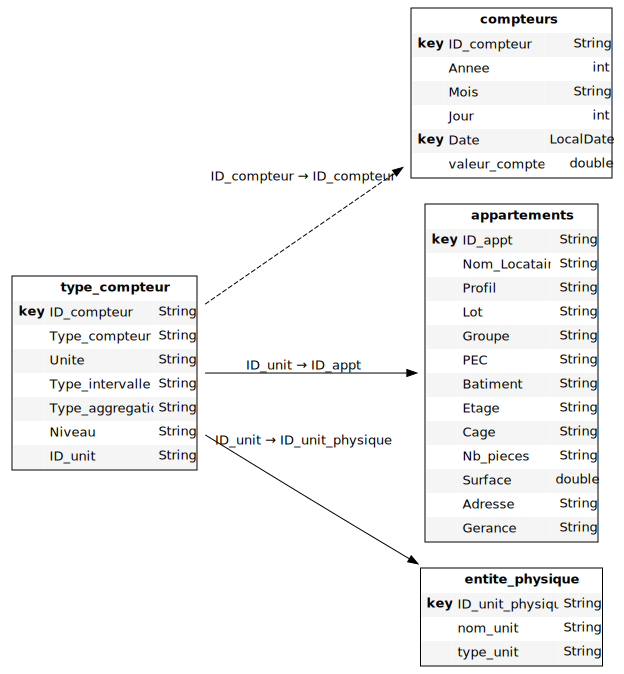

In [9]:
session.stores.schema

In [10]:
# creation d'un cube permettant de voir toutes les valeurs de compteurs ( facture inclus)
# et tous les appartements même ceux sans valeur de compteurs
cube = session.create_cube(store_type_compteurs)

In [11]:
# nettoyage des mesures et hierarchies auto-générées
cube_hierarchies, cube_measures, cube_levels   = cube.hierarchies, cube.measures, cube.levels

In [12]:
cube_hierarchies["Localisation"] = [cube_levels["Groupe"],
                                    cube_levels["PEC"] ,
                                    cube_levels["Batiment"],
                                    cube_levels["Etage"],
                                    cube_levels["Cage"]]
del cube_hierarchies["Groupe"]
del cube_hierarchies["PEC"]
del cube_hierarchies["Batiment"]
del cube_hierarchies["Etage"]
del cube_hierarchies["Cage"]


In [13]:
cube_hierarchies

Hierarchies()

In [30]:
# creation de mesures de base
cube_measures["Valeur_compteur.MOY"] = tt.agg.mean(store_compteurs["valeur_compteur"])
cube_measures["Surface par appartement"] = tt.value(store_appt["Surface"], levels=[cube_levels["ID_unit"]])
cube_measures["Surface.SOMME"] = tt.agg.sum(cube_measures["Surface par appartement"])
cube_measures["Surface de reference"] = tt.parent_value(
    cube_measures["Surface.SOMME"], 
    on=[cube_hierarchies["ID_unit"]],
    apply_filters=False    
)
cube_measures["Part de surface"] = cube_measures["Surface.SOMME"] / cube_measures["Surface de reference"]
cube_measures["Surface.MOY"] = tt.agg.mean(store_appt["Surface"])
# format desmesures de base
cube_measures["Valeur_compteur.MOY"].formatter = "DOUBLE[0.00]"
cube_measures["Surface.SOMME"].formatter = "DOUBLE[0.00]"
cube_measures["Surface.MOY"].formatter = "DOUBLE[0.00]"
cube_measures["Part de surface"].formatter = "DOUBLE[0.00%]"

cube_measures["Surface par appartement"].visible = False

cube_measures

Measures()

In [31]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension installed and enabled to start editing this widget.

In [29]:
session.url

'http://localhost:60204'

In [16]:
# creation de la valeur du compteur en fonction du type d'aggregation et du type d'intervalle
# valeur precedente du compteur depend du type d'intervalle (seulement 2 possibilités pour l'instant Jour ou Semaine)

cube_measures["Valeur_compteur"] = store_compteurs["valeur_compteur"]


In [21]:
cube_measures["Valeur_precedente_compteur"] = tt.where(
    cube_levels["Type_intervalle"] == "Jour", 
           tt.date_shift(
                cube_measures["Valeur_compteur"],
                on=cube_hierarchies["Date"],
                offset="-1D",
                method="previous")  ,
            tt.date_shift(
                cube_measures["Valeur_compteur"],
                on=cube_hierarchies["Date"],
                offset="-1W",
                method="previous")
)
cube_measures["Diff_valeur_compteur"] = cube_measures["Valeur_compteur"] - cube_measures["Valeur_precedente_compteur"]

# la somme dépend du type d'aggregation     
cube_measures["Valeur_compteur.SOMME"] = tt.where(
    cube_levels["Type_aggregation"] == "SUM", 
    tt.agg.sum(cube_measures["Valeur_compteur"]),
    tt.agg.sum(cube_measures["Diff_valeur_compteur"])
)

cube_measures["Valeur_compteur.CUMUL.SOMME"] = tt.where(
    cube_levels["Type_aggregation"] == "SUM", 
    tt.agg.sum(cube_measures["Valeur_compteur"], scope=tt.scope.cumulative(cube_levels["Date"])),
    tt.agg.sum(cube_measures["Diff_valeur_compteur"], scope=tt.scope.cumulative(cube_levels["Date"]))
)

In [22]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension installed and enabled to start editing this widget.